# Stellantis Project: Feature Correlation Analysis

This notebook loads the data saved from the `fit_predict.py` script, specifically:
1. The main DataFrame with final predictions.
2. The DataFrame containing ALL engineered features (raw + LOSO-generated).
3. The list of features that were actually used by the final trained model.

It then allows you to define a subset of features (primarily from the "ALL engineered features" DataFrame)
and plots a correlation heatmap for them.

In [1]:
import math
import requests
import geopandas as gpd
from shapely.geometry import Point as ShapelyPoint
import os
import pandas as pd
import numpy as np
import random
import pickle
import warnings
import h3
import time
from polyline import decode
import traceback # For detailed error logging
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath, **kwargs):
    """
    Loads data from various file types into memory.

    Supports CSV, Parquet, Excel (xls, xlsx), JSON, and Pickle (pkl, pickle) files.

    Args:
        filepath (str): The path to the file to load.
        **kwargs: Additional keyword arguments to pass to the underlying
                  pandas read function (read_csv, read_parquet, read_excel, read_json).
                  These arguments are IGNORED for pickle files.

    Returns:
        pandas.DataFrame: For CSV, Parquet, Excel, JSON files.
        object: The deserialized Python object for Pickle files (could be
                dict, list, DataFrame, etc.).

    Raises:
        ValueError: If the file extension is not supported.
        FileNotFoundError: If the filepath does not exist.
        Exception: Other exceptions specific to the file type or reading process
                   (e.g., pd.errors.ParserError, pickle.UnpicklingError).
    """
    # Check if file exists first for a clearer error
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No such file or directory: '{filepath}'")
    if not os.path.isfile(filepath):
         raise IsADirectoryError(f"Path is not a file: '{filepath}'") # Or similar check
    
    extension = os.path.splitext(filepath)[1].lower()
    if extension == '.csv':
        return pd.read_csv(filepath, **kwargs)
    elif extension == '.parquet':
        return pd.read_parquet(filepath, **kwargs)
    elif extension in ('.xls', '.xlsx'):
        return pd.read_excel(filepath, **kwargs)
    elif extension == '.json':
        return pd.read_json(filepath, **kwargs)
    elif extension in ('.pkl', '.pickle'):
        try:
            with open(filepath, 'rb') as f: # Open in binary read mode ('rb')
                # Load the object using pickle.load
                # Note: We generally don't pass pandas **kwargs to pickle.load
                loaded_object = pickle.load(f)
            return loaded_object
        except pickle.UnpicklingError as e:
            # Raise a specific error if unpickling fails
            raise pickle.UnpicklingError(f"Error unpickling file {filepath}: {e}")
        except Exception as e:
            # Catch other potential errors during file open/read for pickle
            raise Exception(f"An error occurred loading pickle file {filepath}: {e}")
    # --- End Pickle Support ---
    else:
        raise ValueError(f"Unsupported file extension: {extension}")

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # For loading pickle files if HelperFuncs.load_file has issues with it directly

HELPER_FUNC_AVAILABLE = True


In [3]:
# --- Define Paths to Saved Artifacts ---
BASE_OUTPUT_DIR = r"C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Stellantis Project\End-to-End\segments_df" # Main directory

# 1. Main predictions DataFrame (output of fit_predict.py)
#    The filename includes the METHOD, e.g., "_loso_global_residual"
METHOD_SUFFIX = "loso_global_residual" # Make sure this matches the method used in fit_predict.py
MAIN_PREDICTIONS_FILENAME = f"segments_final_predictions_v3_{METHOD_SUFFIX}.parquet"
main_predictions_path = os.path.join(BASE_OUTPUT_DIR, MAIN_PREDICTIONS_FILENAME)

# 2. DataFrame with ALL engineered features
ALL_FEATURES_FILENAME = f"segments_all_engineered_features_{METHOD_SUFFIX}.parquet" # Assuming this naming convention
all_features_path = os.path.join(BASE_OUTPUT_DIR, ALL_FEATURES_FILENAME)

# 3. Text file with the list of features USED by the final model
USED_MODEL_FEATURES_FILENAME = f"used_model_features_{METHOD_SUFFIX}.txt" # Assuming this naming convention
used_model_features_path = os.path.join(BASE_OUTPUT_DIR, USED_MODEL_FEATURES_FILENAME)

print(f"Path for main predictions: {main_predictions_path}")
print(f"Path for all engineered features: {all_features_path}")
print(f"Path for used model features list: {used_model_features_path}")

Path for main predictions: C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Stellantis Project\End-to-End\segments_df\segments_final_predictions_v3_loso_global_residual.parquet
Path for all engineered features: C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Stellantis Project\End-to-End\segments_df\segments_all_engineered_features_loso_global_residual.parquet
Path for used model features list: C:\Users\goldy\OneDrive\Documents\Y-DATA 24-25\Stellantis Project\End-to-End\segments_df\used_model_features_loso_global_residual.txt


In [4]:
# --- Load DataFrames ---
df_main_predictions = None
df_all_engineered_features = None
list_used_model_features = []

# Load main predictions DataFrame
try:
    if HELPER_FUNC_AVAILABLE:
        df_main_predictions = load_file(main_predictions_path)
    else: # Fallback if HelperFuncs not available
        df_main_predictions = pd.read_parquet(main_predictions_path)
    print(f"Successfully loaded main predictions DataFrame. Shape: {df_main_predictions.shape}")
    # print("\nFirst 5 rows of main predictions DataFrame:")
    # display(df_main_predictions.head())
except FileNotFoundError:
    print(f"ERROR: Main predictions file not found at {main_predictions_path}")
except Exception as e:
    print(f"ERROR: Could not load main predictions file: {e}")

# Load "all engineered features" DataFrame
try:
    if HELPER_FUNC_AVAILABLE:
        df_all_engineered_features = load_file(all_features_path)
    else: # Fallback
        df_all_engineered_features = pd.read_parquet(all_features_path)
    print(f"\nSuccessfully loaded 'all engineered features' DataFrame. Shape: {df_all_engineered_features.shape}")
    # print("\nFirst 5 rows of 'all engineered features' DataFrame:")
    # display(df_all_engineered_features.head())
    # print("\nColumns in 'all engineered features' DataFrame:")
    # print(df_all_engineered_features.columns.tolist())
except FileNotFoundError:
    print(f"ERROR: 'All engineered features' file not found at {all_features_path}")
    print("       Make sure the METHOD_SUFFIX in the path definition is correct and the file exists.")
except Exception as e:
    print(f"ERROR: Could not load 'all engineered features' file: {e}")


# Load the list of features used by the model
try:
    with open(used_model_features_path, 'r') as f:
        list_used_model_features = [line.strip() for line in f if line.strip()]
    print(f"\nSuccessfully loaded list of {len(list_used_model_features)} features used by the final model.")
    # print("Used model features:")
    # print(list_used_model_features)
except FileNotFoundError:
    print(f"ERROR: Used model features list file not found at {used_model_features_path}")
except Exception as e:
    print(f"ERROR: Could not load used model features list: {e}")

Successfully loaded main predictions DataFrame. Shape: (5461, 66)

Successfully loaded 'all engineered features' DataFrame. Shape: (2734, 166)

Successfully loaded list of 36 features used by the final model.


In [5]:
# %% [markdown]
# ## 3. Define Subset of Features for Correlation Heatmap
#
# **Instructions:**
# *   Modify the `subset_of_features_for_correlation` list below.
# *   These features should exist as columns in the `df_all_engineered_features` DataFrame (which is the most comprehensive).
# *   You can include raw features, engineered `k_` features, or engineered `others_` features.
# *   Keep the list reasonably small (e.g., 10-25 features) for a readable heatmap with annotations. For larger sets, consider `annot=False`.

# %%
# --- Define the subset of features you want to correlate ---
# --- THIS IS THE LIST YOU NEED TO CUSTOMIZE ---
# Example: A mix of start-of-segment, global prediction, and some 'others' aggregates
# Make sure these column names EXACTLY match those in df_all_engineered_features

if df_all_engineered_features is not None:
    subset_of_features_for_correlation = [
        # Raw features (if they exist directly in df_all_engineered_features,
        # otherwise use their 'k_' prefixed versions if that's how they are stored)
        'soc_seg_start',             # Raw start SoC
        'temp_seg_start',            # Raw start temperature
        'global_pred_soc_seg_delta', # Raw global model prediction

        # Engineered 'k_' features (current segment)
        'k_speed_seg_pred_kph',      # Predicted speed for current segment
        'k_battery_health_seg_start',# Battery health at start of current segment

        # Engineered 'others_' features (aggregates from other segments)
        'others_avg_gt_soc_seg_delta',
        'others_avg_speed_seg_agg_mean_mps',
        'others_std_speed_seg_agg_mean_mps',
        'others_avg_accel_seg_agg_mean',
        'others_rate_stops_per_km',
        'others_avg_residual_error_soc_seg_delta', # Avg error of global model on other segments
        'others_std_residual_error_soc_seg_delta', # Std dev of global model error on other segments

        # Target variables (from df_all_engineered_features)
        'gt_soc_seg_delta',          # Actual SoC change for the segment
        'residual_error_soc_seg_delta', # Global model's error for the segment
        'personal_final_error'       # Final personal model's error for the segment
    ]

    # Filter the list to only include columns that actually exist in the DataFrame
    # This prevents KeyErrors if you mistype a name or a feature wasn't generated.
    actual_subset_for_correlation = [col for col in subset_of_features_for_correlation
                                     if col in df_all_engineered_features.columns]

    missing_from_subset = list(set(subset_of_features_for_correlation) - set(actual_subset_for_correlation))
    if missing_from_subset:
        print(f"\nWARNING: The following requested features were NOT found in df_all_engineered_features and will be excluded from the heatmap:")
        for col in missing_from_subset:
            print(f" - {col}")

    print(f"\nFeatures selected for correlation heatmap ({len(actual_subset_for_correlation)}):")
    for col in actual_subset_for_correlation:
        print(f" - {col}")
else:
    print("\nSkipping feature subset definition as 'df_all_engineered_features' was not loaded.")
    actual_subset_for_correlation = []


Features selected for correlation heatmap (15):
 - soc_seg_start
 - temp_seg_start
 - global_pred_soc_seg_delta
 - k_speed_seg_pred_kph
 - k_battery_health_seg_start
 - others_avg_gt_soc_seg_delta
 - others_avg_speed_seg_agg_mean_mps
 - others_std_speed_seg_agg_mean_mps
 - others_avg_accel_seg_agg_mean
 - others_rate_stops_per_km
 - others_avg_residual_error_soc_seg_delta
 - others_std_residual_error_soc_seg_delta
 - gt_soc_seg_delta
 - residual_error_soc_seg_delta
 - personal_final_error



Calculating correlation matrix for 15 numeric features...


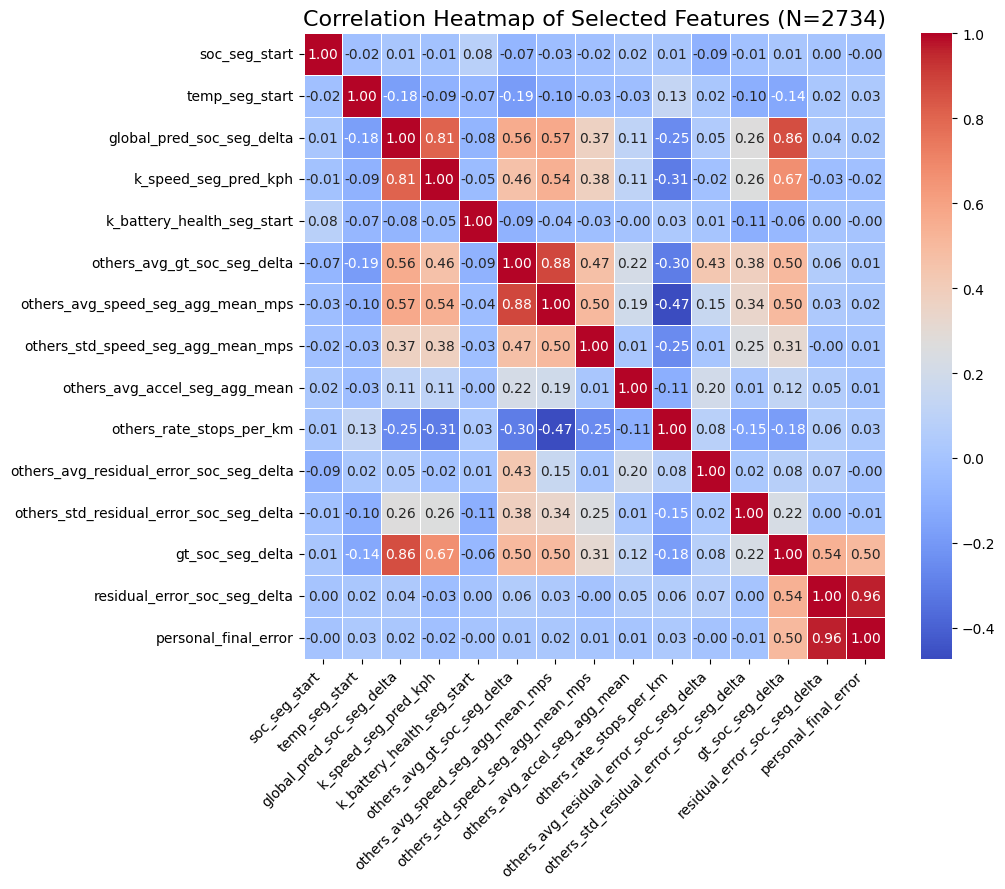

In [6]:
# %% [markdown]
# ## 4. Calculate and Plot Correlation Heatmap

# %%
# --- Calculate Correlation Matrix ---
if df_all_engineered_features is not None and actual_subset_for_correlation:
    # Select only the numeric columns from the subset for correlation
    # (Categorical columns like 'k_car_model_trip' would need encoding first if included)
    numeric_subset_df = df_all_engineered_features[actual_subset_for_correlation].select_dtypes(include=np.number)

    if numeric_subset_df.empty:
        print("\nERROR: No numeric features found in the selected subset for correlation.")
    elif numeric_subset_df.shape[1] < 2:
        print("\nERROR: Need at least two numeric features in the subset to calculate correlations.")
    else:
        print(f"\nCalculating correlation matrix for {numeric_subset_df.shape[1]} numeric features...")
        correlation_matrix = numeric_subset_df.corr()

        # --- Plot Heatmap ---
        plt.figure(figsize=(max(10, len(numeric_subset_df.columns)*0.7),
                            max(8, len(numeric_subset_df.columns)*0.6))) # Adjust size dynamically

        sns.heatmap(correlation_matrix,
                    annot=True,          # Show correlation values
                    cmap='coolwarm',     # Colormap (good for correlations, centers on 0)
                    fmt=".2f",           # Format annotations to 2 decimal places
                    linewidths=.5,       # Add lines between cells
                    cbar=True,           # Show color bar
                    square=False)        # Can set to True if you prefer square cells

        plt.title(f'Correlation Heatmap of Selected Features (N={len(numeric_subset_df)})', fontsize=16)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()

        # print("\nCorrelation Matrix:")
        # display(correlation_matrix)
else:
    if df_all_engineered_features is None:
        print("\nSkipping correlation plot: 'df_all_engineered_features' is not loaded.")
    elif not actual_subset_for_correlation:
        print("\nSkipping correlation plot: No valid features were selected for correlation (check your `subset_of_features_for_correlation` list).")



--- Analyzing Features Used by the Final Model (36 features) ---

Correlation heatmap for features used by the final model (33 numeric features):


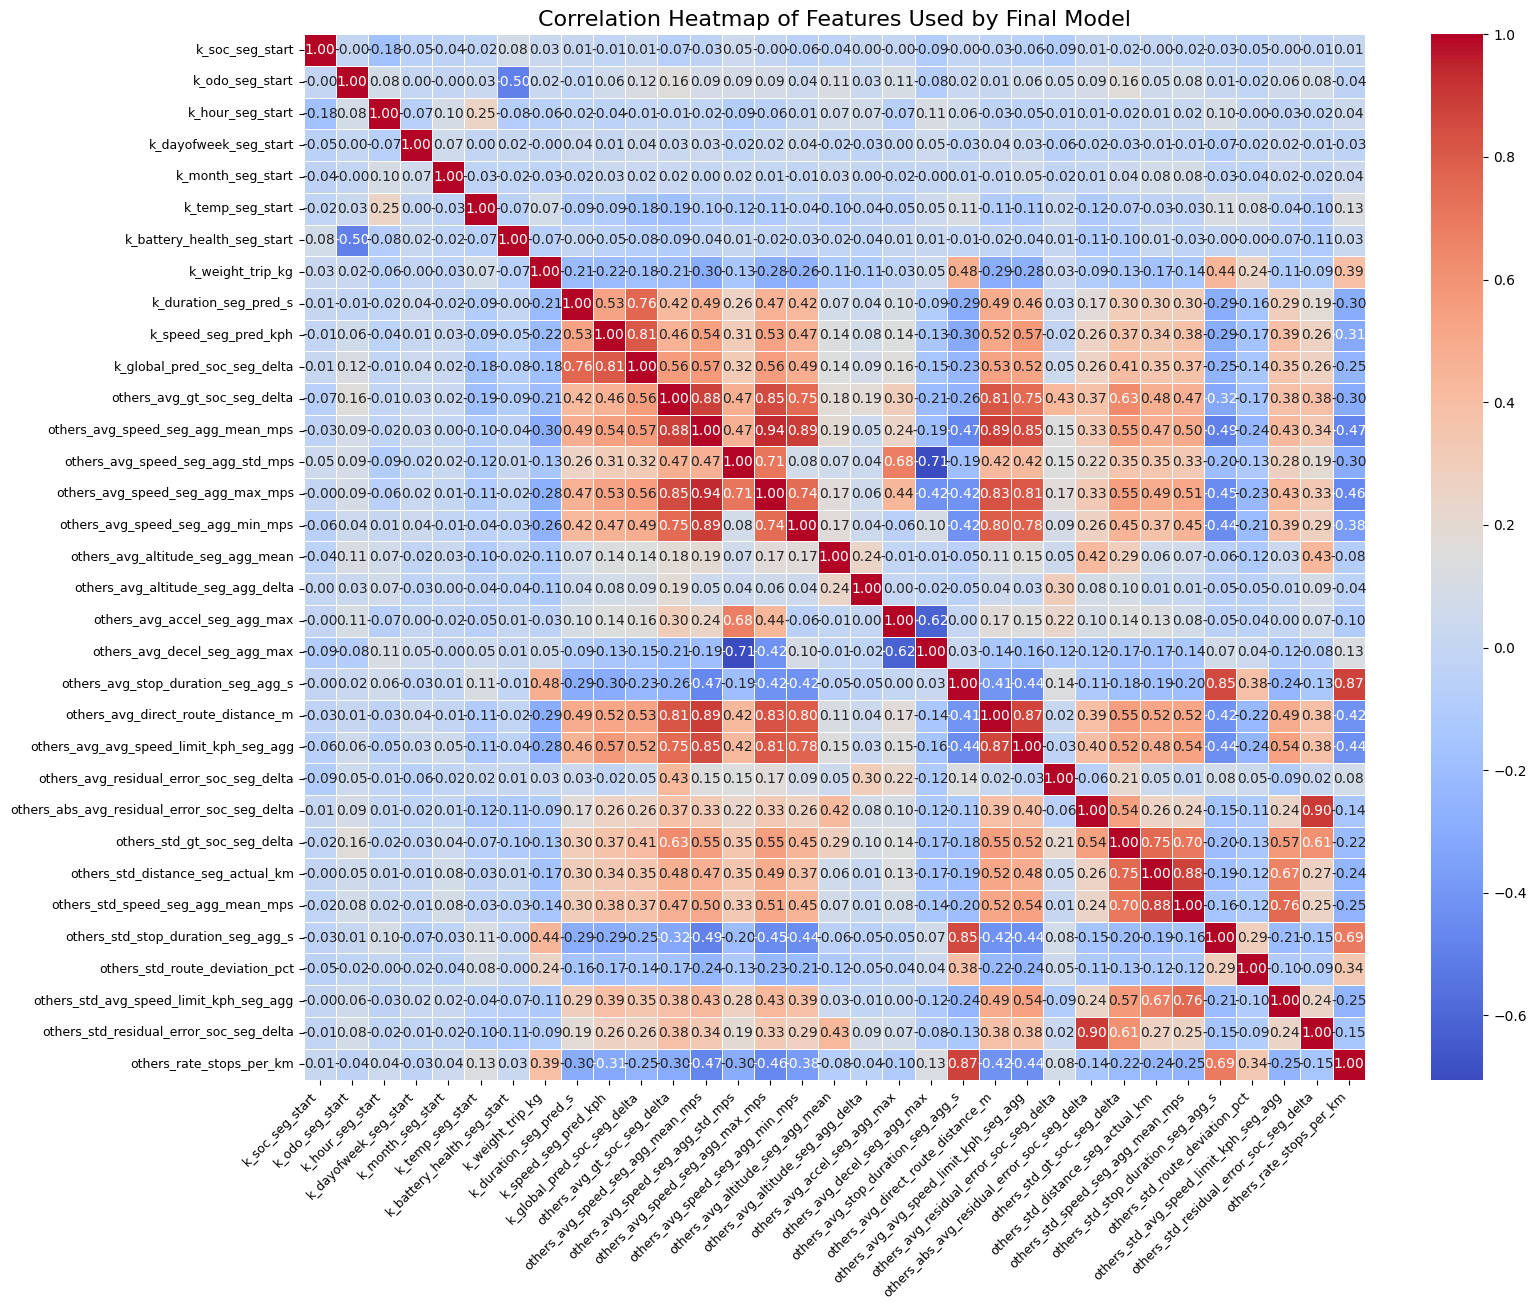

In [7]:

# %% [markdown]
# ## 5. (Optional) Explore Features Used by the Final Model
#
# You can use `list_used_model_features` to further analyze the specific features that your best `loso_global_residual` model was trained on. For example, you could create a correlation heatmap specifically for these features.

# %%
if list_used_model_features and df_all_engineered_features is not None:
    print(f"\n--- Analyzing Features Used by the Final Model ({len(list_used_model_features)} features) ---")

    # Ensure these features exist in the loaded 'all_engineered_features' DataFrame
    # (They should, as they were derived from it)
    final_model_features_present = [f for f in list_used_model_features if f in df_all_engineered_features.columns]

    if len(final_model_features_present) != len(list_used_model_features):
        print("Warning: Some features listed in 'used_model_features.txt' were not found in the 'df_all_engineered_features'. This is unexpected.")
        print(f"Found: {final_model_features_present}")

    if final_model_features_present:
        numeric_final_model_features_df = df_all_engineered_features[final_model_features_present].select_dtypes(include=np.number)

        if numeric_final_model_features_df.shape[1] >= 2:
            print(f"\nCorrelation heatmap for features used by the final model ({numeric_final_model_features_df.shape[1]} numeric features):")
            correlation_matrix_final_model = numeric_final_model_features_df.corr()

            plt.figure(figsize=(max(10, numeric_final_model_features_df.shape[1]*0.5),
                                max(8, numeric_final_model_features_df.shape[1]*0.4)))
            sns.heatmap(correlation_matrix_final_model, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
            plt.title('Correlation Heatmap of Features Used by Final Model', fontsize=16)
            plt.xticks(rotation=45, ha='right', fontsize=9)
            plt.yticks(fontsize=9)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough numeric features among the 'used_model_features' to plot a meaningful correlation heatmap.")
    else:
        print("No valid features from 'list_used_model_features' found in the DataFrame to analyze.")

else:
    print("\nSkipping analysis of 'used_model_features': List is empty or 'df_all_engineered_features' not loaded.")

In [8]:
# %% [markdown]
# ## 6. Correlation with Ground Truth (gt_soc_seg_delta)
#
# This section calculates and plots the correlation of selected feature subsets with the primary ground truth target: `gt_soc_seg_delta`.

# %%
# --- Define the Ground Truth Target Column ---
GROUND_TRUTH_TARGET_COL = 'gt_soc_seg_delta'

# --- Helper Function to Plot Sorted Horizontal Bar Chart of Correlations ---
def plot_correlation_with_target_barh(df_features, feature_list, target_col, title_prefix=""):
    """
    Calculates correlation of features in feature_list with target_col from df_features
    and plots a sorted horizontal bar chart.
    """
    if target_col not in df_features.columns:
        print(f"ERROR: Target column '{target_col}' not found in the DataFrame.")
        return
    if not feature_list:
        print("ERROR: Feature list is empty.")
        return

    # Select only numeric features from the list + the target column
    numeric_features_in_list = df_features[feature_list].select_dtypes(include=np.number).columns.tolist()
    if not numeric_features_in_list:
        print(f"WARNING: No numeric features found in the provided list for '{title_prefix}'. Skipping plot.")
        return

    # Create a DataFrame with the numeric features and the target
    df_for_corr = df_features[numeric_features_in_list + [target_col]].copy()

    # Calculate correlations with the target column
    correlations = df_for_corr.corr()[target_col].drop(target_col) # Drop self-correlation

    if correlations.empty:
        print(f"Could not calculate correlations for '{title_prefix}'. Ensure features are numeric and not all NaNs.")
        return

    # Sort by absolute correlation value for better visualization of strength,
    # or sort by value if you prefer to see positive/negative grouping.
    # Let's sort by value (descending) to group positive and negative.
    sorted_correlations = correlations.sort_values(ascending=False)

    plt.figure(figsize=(10, max(6, len(sorted_correlations) * 0.4))) # Adjust height dynamically
    bars = plt.barh(sorted_correlations.index, sorted_correlations.values,
                    color=['skyblue' if x > 0 else 'salmon' for x in sorted_correlations.values])

    # Add text annotations for the correlation values on the bars
    for bar in bars:
        width = bar.get_width()
        label_x_pos = width + (0.02 if width >= 0 else -0.02) # Small offset
        plt.text(label_x_pos,
                 bar.get_y() + bar.get_height()/2,
                 f'{width:.2f}',
                 va='center',
                 ha='left' if width >= 0 else 'right',
                 fontsize=9)

    plt.xlabel(f'Correlation with {target_col}', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'{title_prefix}Correlation of Features with {target_col}', fontsize=14)
    plt.axvline(0, color='grey', linewidth=0.8, linestyle='--') # Add a line at 0 correlation
    plt.grid(axis='x', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()


--- Plotting Correlation with 'gt_soc_seg_delta' for User-Defined Subset ---


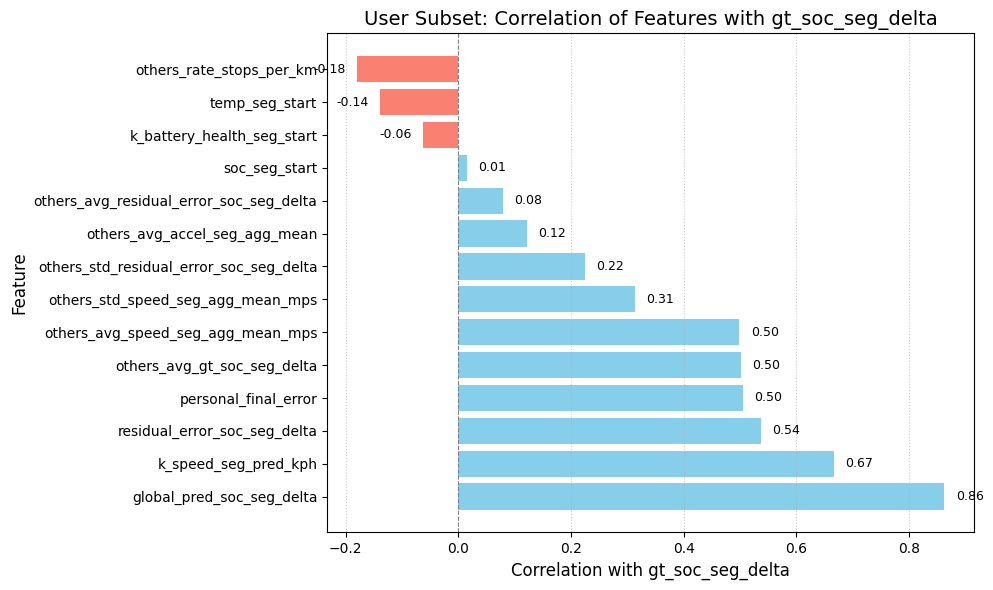

In [9]:
# %% [markdown]
# ### 6.1 Correlation for User-Defined Subset of Features

# %%
# --- Plot for the user-defined subset of features ---
if df_all_engineered_features is not None and actual_subset_for_correlation:
    print(f"\n--- Plotting Correlation with '{GROUND_TRUTH_TARGET_COL}' for User-Defined Subset ---")
    # Ensure the target column itself is not in the feature list being passed for correlation calculation
    features_for_this_plot = [f for f in actual_subset_for_correlation if f != GROUND_TRUTH_TARGET_COL]
    plot_correlation_with_target_barh(df_all_engineered_features,
                                      features_for_this_plot,
                                      GROUND_TRUTH_TARGET_COL,
                                      title_prefix="User Subset: ")
else:
    if df_all_engineered_features is None:
        print("\nSkipping user-subset correlation plot: 'df_all_engineered_features' is not loaded.")
    elif not actual_subset_for_correlation:
        print("\nSkipping user-subset correlation plot: No valid features were selected in `actual_subset_for_correlation`.")


--- Plotting Correlation with 'gt_soc_seg_delta' for Features Used by Final Model ---


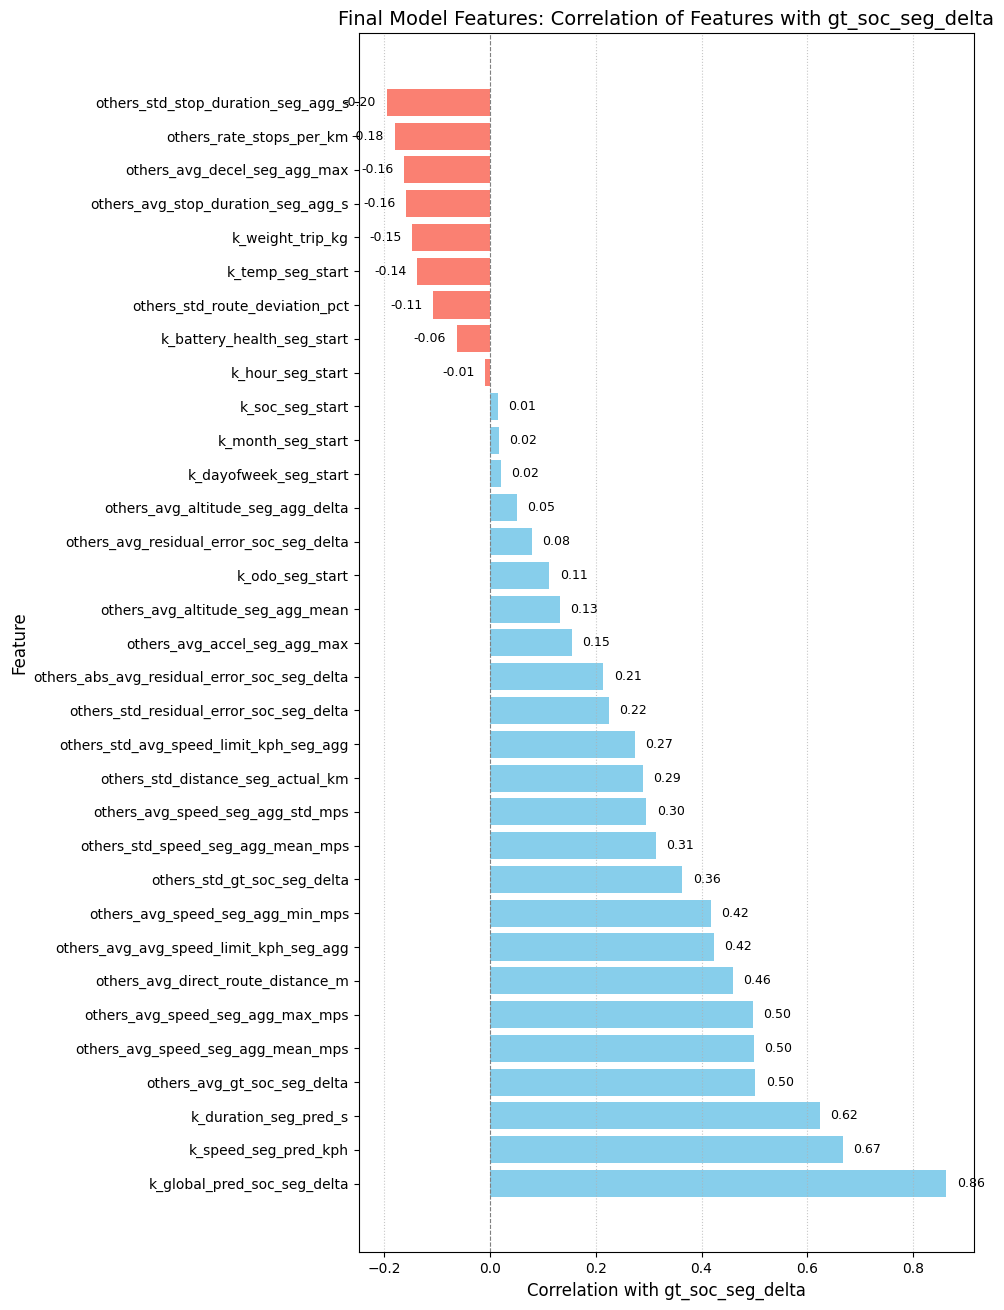

In [10]:
# %% [markdown]
# ### 6.2 Correlation for Features Used by the Final Model

# %%
# --- Plot for the features used by the final model ---
if df_all_engineered_features is not None and list_used_model_features:
    print(f"\n--- Plotting Correlation with '{GROUND_TRUTH_TARGET_COL}' for Features Used by Final Model ---")
    # Ensure the target column itself is not in the feature list being passed
    features_for_this_plot_final_model = [f for f in list_used_model_features if f != GROUND_TRUTH_TARGET_COL]

    # Filter list_used_model_features to only those present in df_all_engineered_features
    # (though they should all be present if generated correctly)
    final_model_features_present_for_corr = [f for f in features_for_this_plot_final_model
                                             if f in df_all_engineered_features.columns]

    if final_model_features_present_for_corr:
        plot_correlation_with_target_barh(df_all_engineered_features,
                                          final_model_features_present_for_corr,
                                          GROUND_TRUTH_TARGET_COL,
                                          title_prefix="Final Model Features: ")
    else:
        print("No valid features from 'list_used_model_features' (excluding target) found in the DataFrame to plot correlations.")
else:
    if df_all_engineered_features is None:
        print("\nSkipping final model features correlation plot: 'df_all_engineered_features' is not loaded.")
    elif not list_used_model_features:
        print("\nSkipping final model features correlation plot: 'list_used_model_features' is empty.")